In [1]:
import numpy as np
import interpolation
import lobatto
import matplotlib.pyplot as plt
import matrix_generator
import system
import element

# Solving Incompressible Navier Stokes using Discontinuous Galerkin methods

### Manan Doshi
### Prof. Shivasubramanian Gopalakrishnan

# Core idea of the Galerkin method

- We work the a finite function space $V_n \subseteq V$ onto which we project our governing equation.
- "Weak formulation"
- Since we satisfy the governing equation in the subspace $V_n$, the errors are perpendicular to the subspace

# Background

## Interpolation

### 1D
$$L^N_i(x) = \prod_{j=0, j\neq i}^{N} \frac{x-x_j}{x_j-x_i}$$
$$f^N(x) = \sum_{i=0}^{N}L_i^N(x)f(x_i)$$
### 2D
$$L_{ij}^{NM}(x,y) = L_i^{N}(x_i) L_j^{M}(y_j)$$
$$f^{MN}(x,y) = \sum_{i=0}^{N} \sum_{j=0}^{M} L_{ij}^{NM}(x,y) f(x_i,y_j)$$

## DIfferentiation

### 1D
$$f^{'N}(x) = \sum_{i=0}^{N}L_i^{'N}(x)f(x_i)$$
### 2D
$$\frac{\partial f^{MN}(x,y)}{\partial x} = \sum_{i=0}^{N} \sum_{j=0}^{M} L_i^{'N}(x_i) * L_j^{M}(y_j) f(x_i,y_j)$$
$$\frac{\partial f^{MN}(x,y)}{\partial y} = \sum_{i=0}^{N} \sum_{j=0}^{M} L_i^{N}(x_i) * L_j^{'M}(y_j) f(x_i,y_j)$$

## Integration

$$\int f(x) dx = \sum w(i)f(x_i)$$

### Choice of nodes
- Legendre
- Lobatto
- Equispaced

# Spectral method: Single element for the system

## Function space

- Choose nodes $x_0, x_1, ... x_n$
- Basis functions: Lagrange interpolating polynomials for the set of nodes
- Function space: All polynomials of degree $N-1$

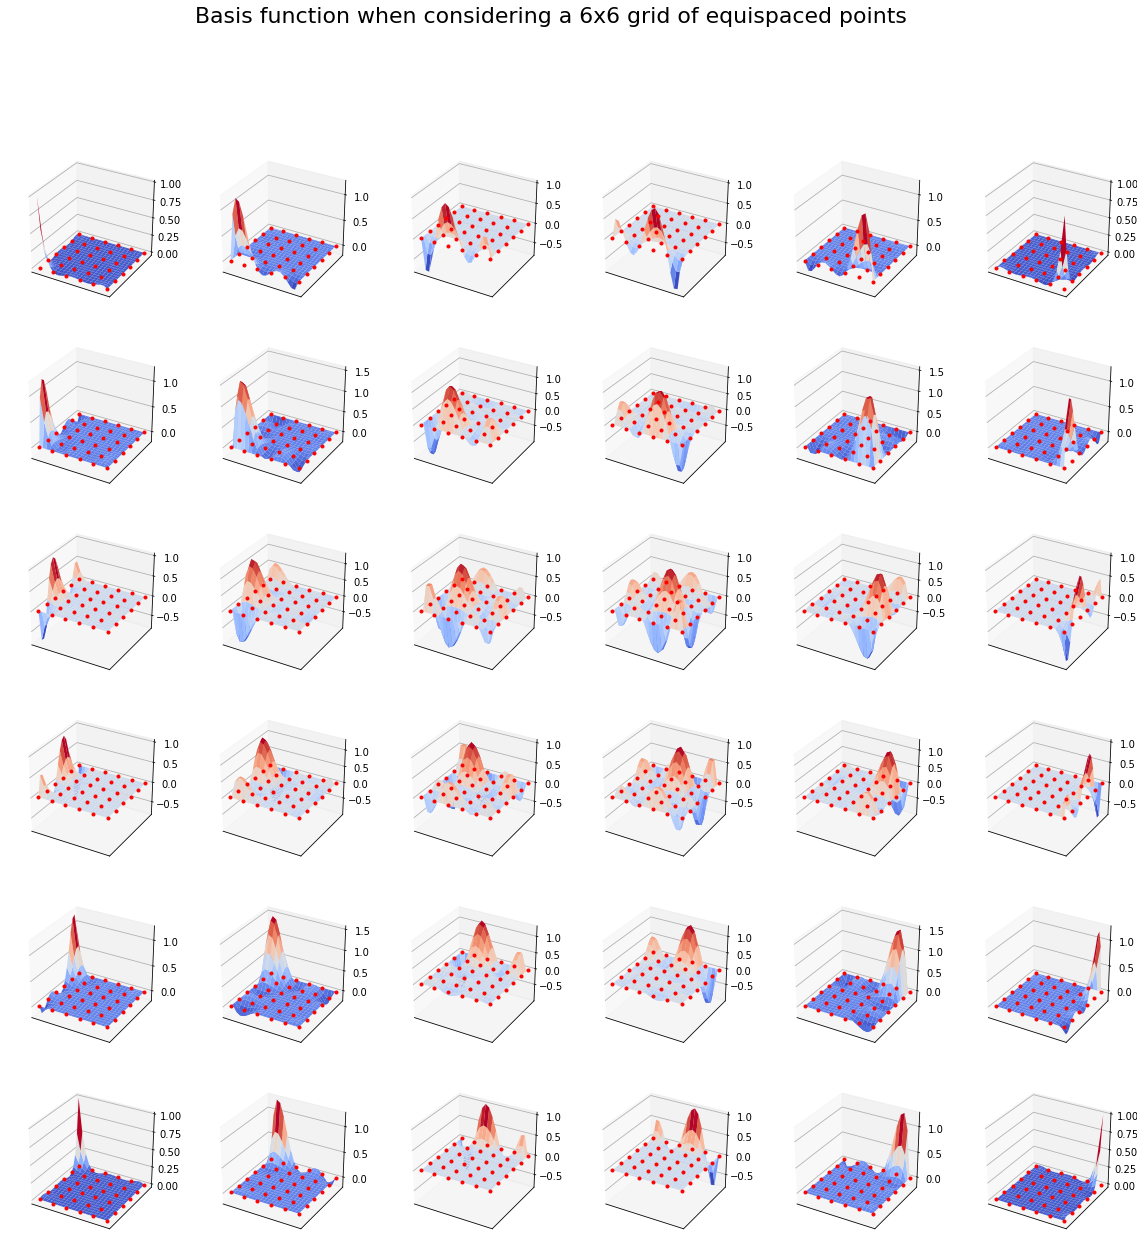

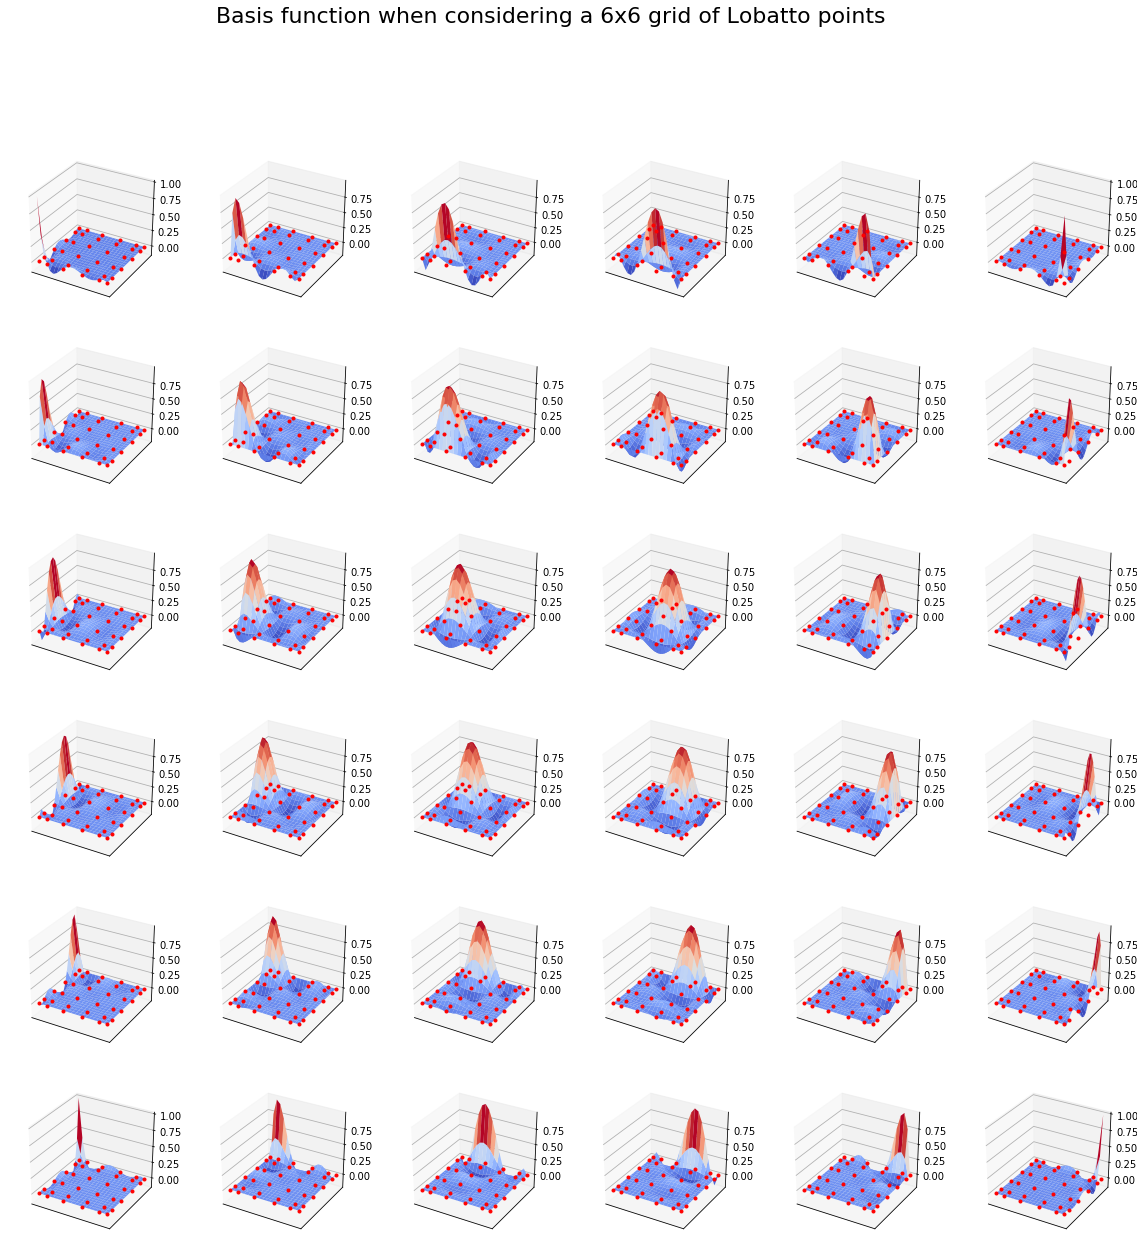

In [5]:
plt.show()

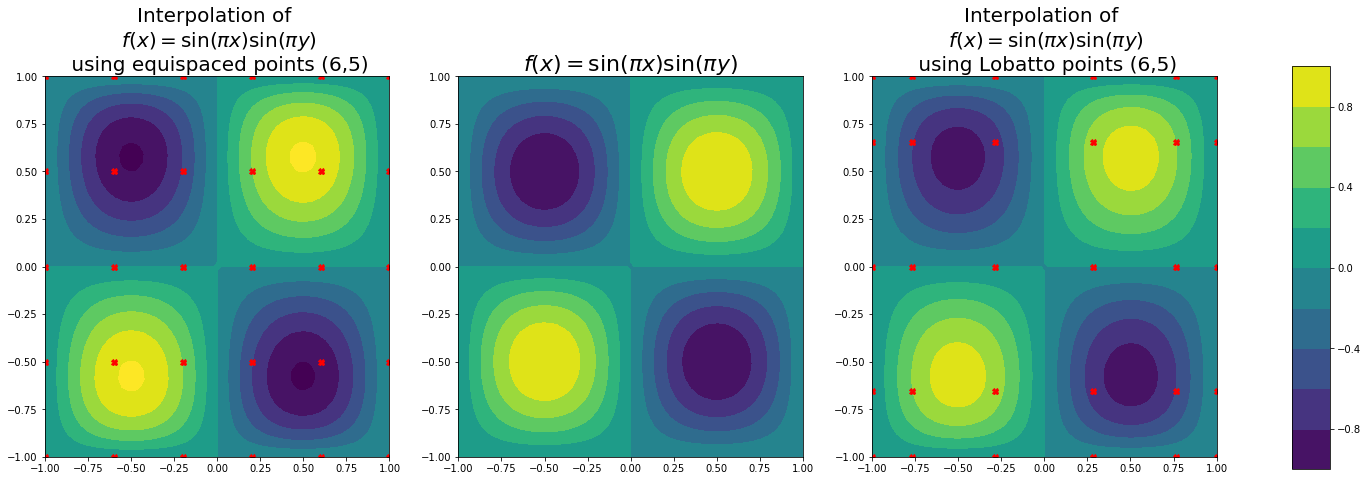

In [24]:
plt.show()

- Basis functions corresponding to lobatto nodes tend to behave better and don't overshoot over 1. Interpolation seems to be more accurate.

# Weak formulation

Governing equation: $$\frac{\partial q}{\partial t} = f(q)$$
Inner product in the function space: $$f \cdot g = \int_{\Omega} fg d\Omega$$


Projecting the governing equation on the function space:
$$\int_{\Omega}\Psi \frac{\partial q}{\partial t}d\Omega = \int_{\Omega}\Psi f(q) d\Omega$$
$$\int_{\Omega}\Psi \frac{\partial q^N}{\partial t}d\Omega = \int_{\Omega}\Psi f^N(q) d\Omega$$
The above relation has to hold for every basis function $\psi_i$ into the function space.
$$\int_{\Omega}\psi_i \sum_j \psi_j \frac{\partial q_j^N}{\partial t}d\Omega = \int_{\Omega}\psi_i f(q) d\Omega$$

Taking the summation out of the integral and taking $\frac{\partial q_j^N}{\partial t}$ out,
$$ \sum_j (\int_{\Omega}\psi_i \psi_j d\Omega) \frac{\partial q_j^N}{\partial t} = \int_{\Omega}\Psi f(q) d\Omega$$

This can be reduced to the following expression
$$M \frac{\partial q_j^N}{\partial t} = RHS$$

where M, the "Mass matrix" is defined as
$$M_{ij} = \int_{\Omega}\psi_i \psi_j d\Omega$$

- Exact vs. Inexact integration

# Multiple elements: Continuous vs Discontinuous Galerkin

### Continuous Galerkin

- Boundary elements shared
- Equations coupled

### Discontinuous Galerkin

- Boundary elements not share
- Need "smart" ways to compute flux to ensure propogation of information
- Can run in parallel. Inter-node communication limited to flux terms

## Difussion

Governing equation:
$\frac{\partial T}{\partial t} = \alpha \nabla^2 T$
We break this into two equations:
$$\Theta = \nabla T \\
\frac{\partial T}{\partial t} = \alpha \nabla \cdot \Theta$$

We first solve for $\Theta$
$$ \theta_x = \frac{\partial T}{\partial x} \\ \theta_y = \frac{\partial T}{\partial y}$$

Proceeding as earlier,
$$M\Theta^N = \int_{\Omega}\Psi \nabla T d\Omega \\
 M_i\Theta^N = \int_{\Omega}\psi_i \nabla  (\sum_j \psi_j T_j) d\Omega \\
 M_i\Theta^N =  \sum_j \int_{\Omega}\nabla(\psi_j \psi_i) T_j d\Omega - \sum_j \int_{\Omega}\nabla( \psi_i )\psi_j T_j d\Omega\\
 M_i\Theta^N = \sum_j ([\psi_i \psi_j]_{\Gamma} T_j - \int_{\Omega}\psi_j\nabla\psi_i T_j d\Omega)\\$$

The first term will be evaluated at the boundaries. This can be rewritten as matrix vector equation:

$$M\Theta^N = FT_{boundary} - DT$$

F and T are the flux and derivative matrices respectively.
$$F_{ij} = [\psi_i \psi_j]_{\Gamma}$$
$$D_{ij} = \psi_j\nabla\psi_i$$

Solving the second part:

\begin{align}
\frac{\partial T}{\partial t} &= \alpha \nabla \cdot \Theta\\
\int_\Omega \Psi \frac{\partial T}{\partial t} d\Omega &= \alpha \int_\Omega \Psi \nabla \cdot \Theta d\Omega\\
M_i\frac{\partial T_j}{\partial t} &= \sum_j ([\psi_i \psi_j]_{\Gamma} \Theta_j - \int_{\Omega}\psi_j\nabla\psi_i \Theta_j d\Omega)\\
M\frac{\partial T_j}{\partial t} &= F \Theta_{boundary} - D \Theta \\
\end{align}

# Flux

The flux term deals with just the boundary values. However, the boundary values here are not clear. We could use the boundary values of this cell or that of the neighboring cell. If we use the boundary values of this cell only, it will lead to no transfer of information between cells. Moreover, we need our flux formulation to be conservative by design; That is, the outflux/influx into this cell at a certain boundary should be equal to the influx/outflux for the neighboring cell through the same boundary.

### Central flux
The boundary values are taken as average of the two adjecant cells.
$$T^{*} = \frac{T^{e} + T^{n}}{2}$$

### Rusanov flux
This basically generalises the "Forward difference" scheme. Here, the boundary value is taken from the "upstream" element. Advection (expectedly) fails if we don't use Rusanov flux. We use central flux for computing the derivatives of T since there is no concept of "upstream" there.


### Example: Temperature distrigution on a 2D conducting plate with dirichlet boundaries

The right wall is maintained at $T = \sin{\pi y}$ and all the other walls are maintained at $T = 0$. The thermal conductivity ($\alpha$) is set at 0.1. The time step for all of the simulations is 0.1ms and the time horizon is 2sec. The solution is compared to the 2D steady state temperature distribution that can be computed analytically. The order in X and Y is varied and the errors are plotted. The first set of plots are generated using inexact integration and the second set using exact. You can see that the difference in errors is fairly small.

Note: This is a spectral method. There is only one cell.

In [2]:
import system
import convectiveSolver
import numpy as np
import matplotlib.pyplot as plt
from utilities import *

def one(args, factor=1.0):
    x,y = args["x"], args["y"]
    return factor*np.ones_like(x);

def zero(args):
    x,y = args["x"], args["y"]
    return np.zeros_like(x)

def sin_y(args, factor=1.0):
    x,y = args["x"], args["y"]
    return factor*np.sin(np.pi*y);

boundary_u = {'N':{'type':'dirichlet','val':zero, 'args':["x","y"]},
              'E':{'type':'dirichlet','val':zero, 'args':["x","y"]},
              'W':{'type':'dirichlet','val':zero, 'args':["x","y"]}, 
              'S':{'type':'dirichlet','val':zero, 'args':["x","y"]}}

boundary_v = {'N':{'type':'dirichlet' ,'val':zero, 'args':["x","y"]},
              'E':{'type':'dirichlet' ,'val':zero, 'args':["x","y"]},
              'W':{'type':'dirichlet' ,'val':zero, 'args':["x","y"]}, 
              'S':{'type':'dirichlet' ,'val':zero, 'args':["x","y"]}}

boundary_T = {'N':{'type':'dirichlet' ,'val':zero, 'args':["x","y"]},
              'E':{'type':'dirichlet' ,'val':sin_y,  'args':["x","y"]},
              'W':{'type':'dirichlet' ,'val':zero, 'args':["x","y"]}, 
              'S':{'type':'dirichlet' ,'val':zero, 'args':["x","y"]}}
boundaries = {'u':boundary_u,
              'v':boundary_v,
              'T':boundary_T,}
init = {'u':{'val':zero,'args':["x","y"]},
        'v':{'val':zero,'args':["x","y"]},
        'T':{'val':zero,'args':["x","y"]}}

In [3]:
for i, numpoints in enumerate(order):
    s = convectiveSolver.convectiveSolver(init=init, boundaries=boundaries, mx=numpoints, my=numpoints, nx=1, ny=1,xmin=0.0,ymin=0.0, alpha=0.1, exact=False)
    s.solve(dt=1e-4, Th=2e0)
    sys = s.system
    sys.computeSample('T')
    x   = sys.properties["x_sample"]
    y   = sys.properties["y_sample"]
    T   = sys.properties["T_sample"]
    T_exact = np.sin(np.pi*y)*np.sinh(np.pi*x)/np.sinh(np.pi)

NameError: name 'order' is not defined

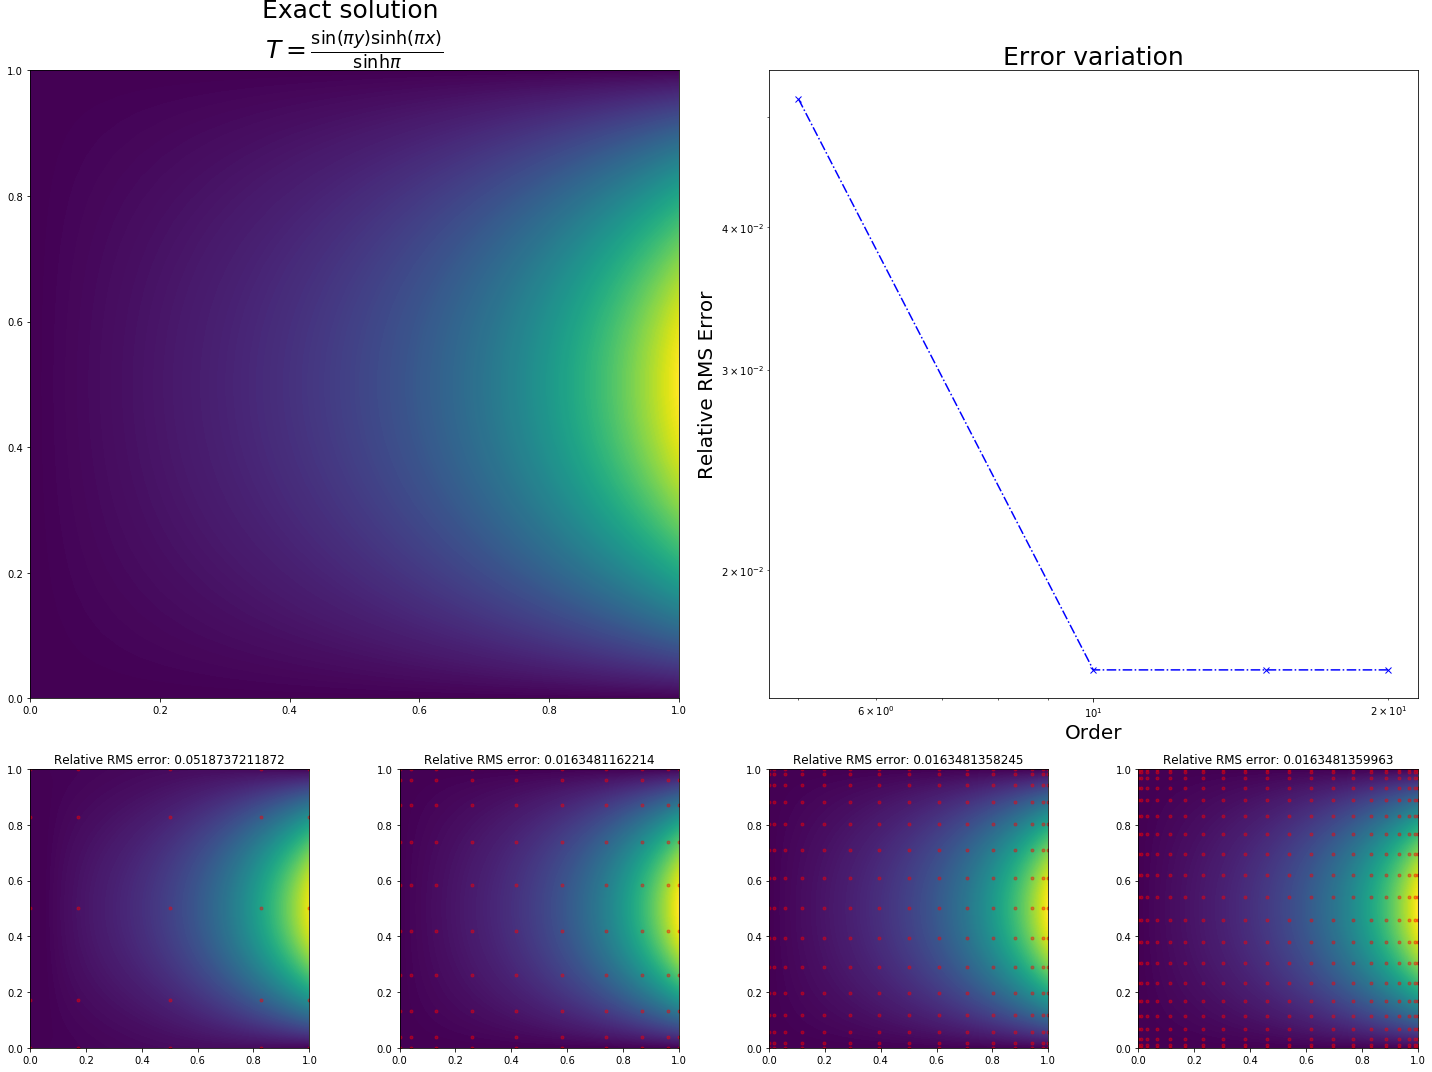

In [27]:
order = [5,10,15,20]
for i, numpoints in enumerate(order):
    s = convectiveSolver.convectiveSolver(init=init, boundaries=boundaries, mx=numpoints, my=numpoints, nx=1, ny=1,xmin=0.0,ymin=0.0, alpha=0.1, exact=True)
    s.solve(dt=1e-4, Th=2e0)
    sys = s.system
    sys.computeSample('T')
    x   = sys.properties["x_sample"]
    y   = sys.properties["y_sample"]
    T   = sys.properties["T_sample"]
    T_exact = np.sin(np.pi*y)*np.sinh(np.pi*x)/np.sinh(np.pi)


### Multiple elements

Breaking up the domain into multiple cells is beneficial since it reduces the size of the matrices/increases the number of sampling points. However, higher number of cells also means that you'll have to repeat the matrix vector operations that many times.

If we were to use a zeroeth order scheme, it would essentially be like a finite volume scheme where every cell has a single value.

We will now run the same exaple but will vary the number of elements too keeping the total number of nodes constant to observe how the error varies. We will just be using inexact integration for this one.

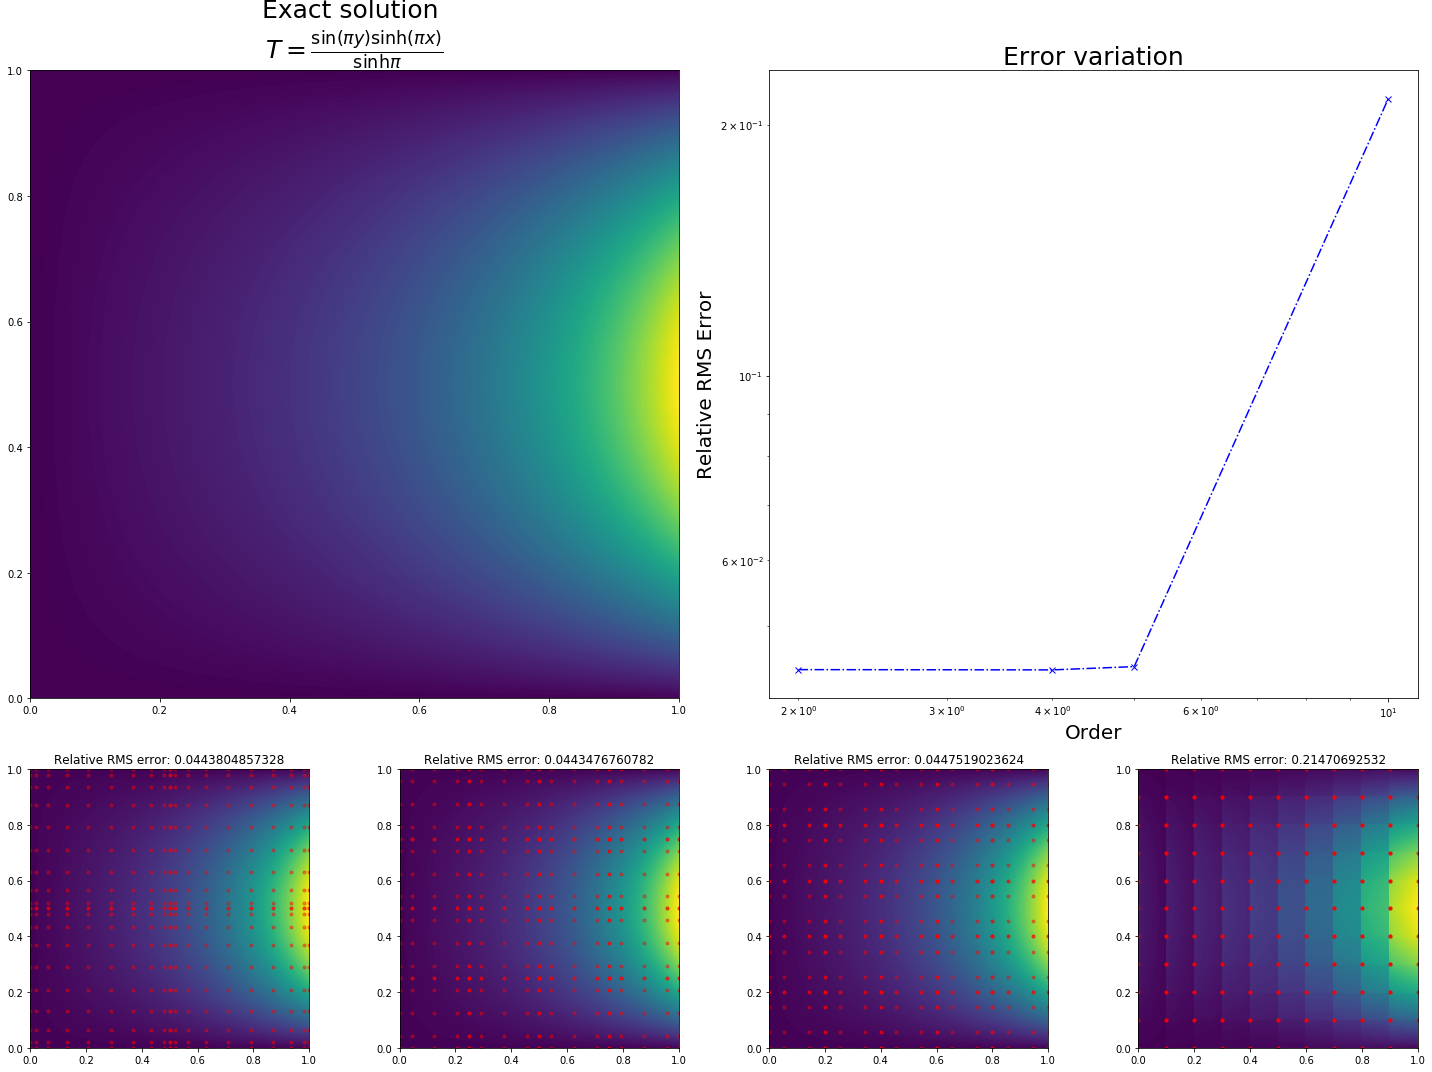

### Example: Diffusion of a Gaussian Temperature distribution

A spectral method works poorly for this problem, perhaps because of very low sampling provided by the lobatto points near the center. Note that the lower accuracy near the borders is due to the inaccurate boundary conditions. The analytical solution is for the boundaries being infinitely far away from the gaussian Temperature distribution.

In [56]:
def gaussian(args):
    x,y = args["x"], args["y"]
    return (1/(0.1))*np.exp(-(x**2+y**2)/(0.4*0.1))

boundary_u = {'N':{'type':'dirichlet','val':zero, 'args':["x","y"]},
              'E':{'type':'dirichlet','val':zero, 'args':["x","y"]},
              'W':{'type':'dirichlet','val':zero, 'args':["x","y"]}, 
              'S':{'type':'dirichlet','val':zero, 'args':["x","y"]}}

boundary_v = {'N':{'type':'dirichlet' ,'val':zero, 'args':["x","y"]},
              'E':{'type':'dirichlet' ,'val':zero, 'args':["x","y"]},
              'W':{'type':'dirichlet' ,'val':zero, 'args':["x","y"]}, 
              'S':{'type':'dirichlet' ,'val':zero, 'args':["x","y"]}}

boundary_T = {'N':{'type':'dirichlet' ,'val':zero, 'args':["x","y"]},
              'E':{'type':'dirichlet' ,'val':zero, 'args':["x","y"]},
              'W':{'type':'dirichlet' ,'val':zero, 'args':["x","y"]}, 
              'S':{'type':'dirichlet' ,'val':zero, 'args':["x","y"]}}
boundaries = {'u':boundary_u,
              'v':boundary_v,
              'T':boundary_T,}
init = {'u':{'val':zero,    'args':["x","y"]},
        'v':{'val':zero,    'args':["x","y"]},
        'T':{'val':gaussian,'args':["x","y"]}}

s = convectiveSolver.convectiveSolver(init=init, boundaries=boundaries, mx=10, my=10, nx=5, ny=5, alpha=0.1, exact=True)
s.solve(dt=1e-4, Th=0.2)

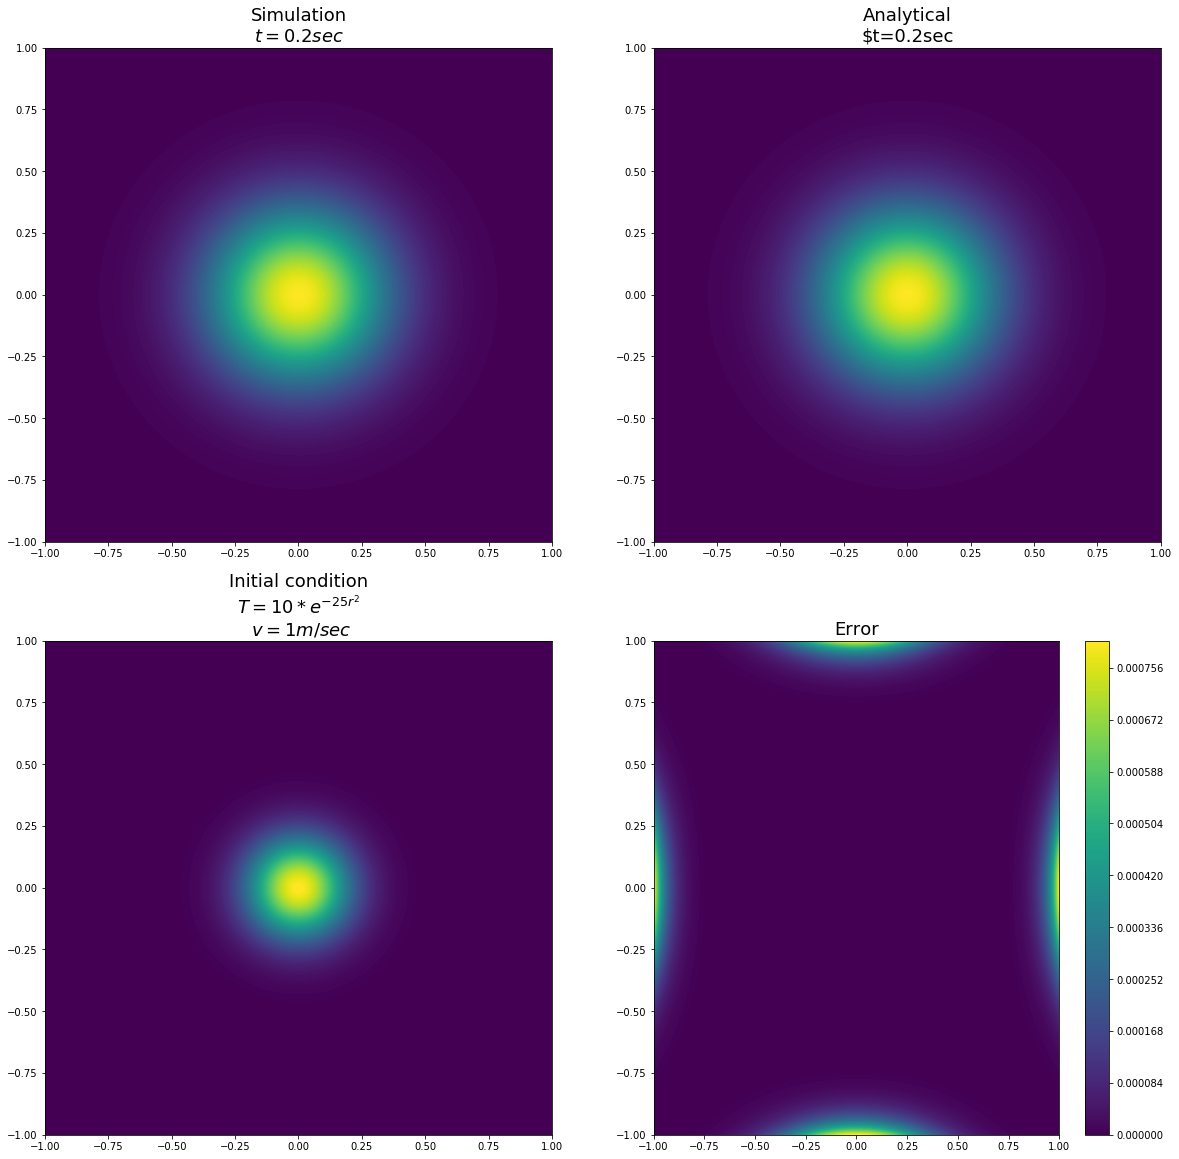

## Advection

Consider the governing equation $$\frac{\partial q}{\partial T} + \nabla \cdot (uT) = 0$$
We calculate $f = uT$ and proceed exactly as we did for the second step of diffusion. We need to use the rusanov flux here.

### Example: Pure advetion of a gaussian temperature profile

Here, we compare an implementation using rusanov flux and centered flux for advection. Rusanov flux clearly gives better results

#### Using Rusanov flux

In [43]:
def gaussian(args):
    x,y = args["x"], args["y"]
    return np.exp(-(x**2+y**2)*100)

def exact(x,y,t):
    return np.exp(-(x**2+(y-1.0*t)**2)*100)

boundary_u = {'N':{'type':'dirichlet','val':zero, 'args':["x","y"]},
              'E':{'type':'dirichlet','val':zero, 'args':["x","y"]},
              'W':{'type':'dirichlet','val':zero, 'args':["x","y"]}, 
              'S':{'type':'dirichlet','val':zero, 'args':["x","y"]}}

boundary_v = {'N':{'type':'dirichlet' ,'val':one, 'args':["x","y"]},
              'E':{'type':'dirichlet' ,'val':one, 'args':["x","y"]},
              'W':{'type':'dirichlet' ,'val':one, 'args':["x","y"]}, 
              'S':{'type':'dirichlet' ,'val':one, 'args':["x","y"]}}

boundary_T = {'N':{'type':'dirichlet' ,'val':zero, 'args':["x","y"]},
              'E':{'type':'dirichlet' ,'val':zero, 'args':["x","y"]},
              'W':{'type':'dirichlet' ,'val':zero, 'args':["x","y"]}, 
              'S':{'type':'dirichlet' ,'val':zero, 'args':["x","y"]}}
boundaries = {'u':boundary_u,
              'v':boundary_v,
              'T':boundary_T,}
init = {'u':{'val':zero,    'args':["x","y"]},
        'v':{'val':one,    'args':["x","y"]},
        'T':{'val':gaussian,'args':["x","y"]}}

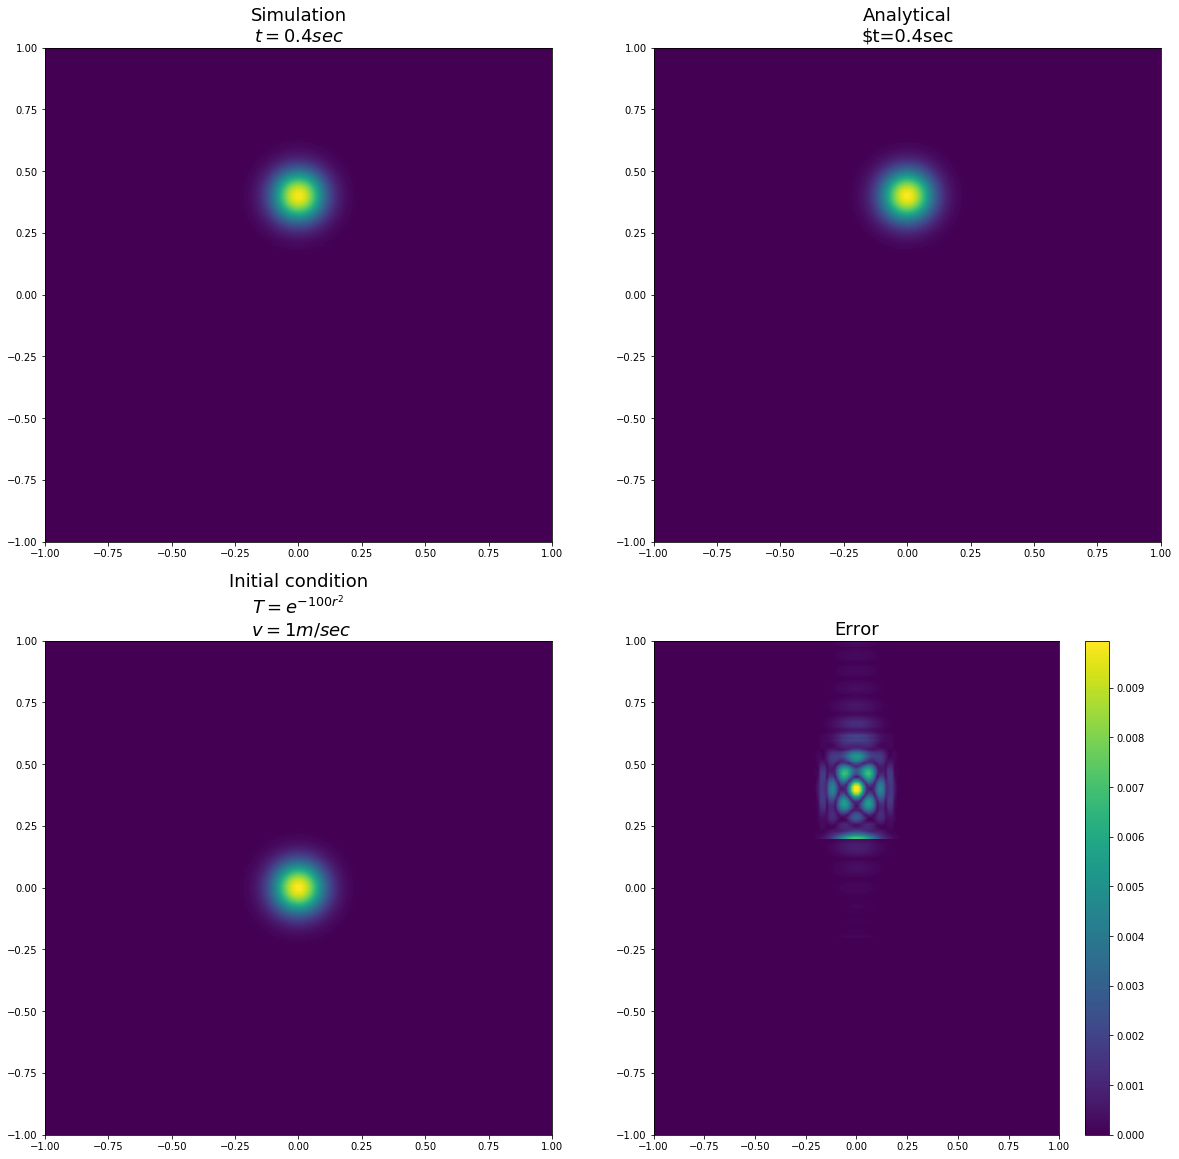

In [54]:
plt.show()

#### Using central flux for advection

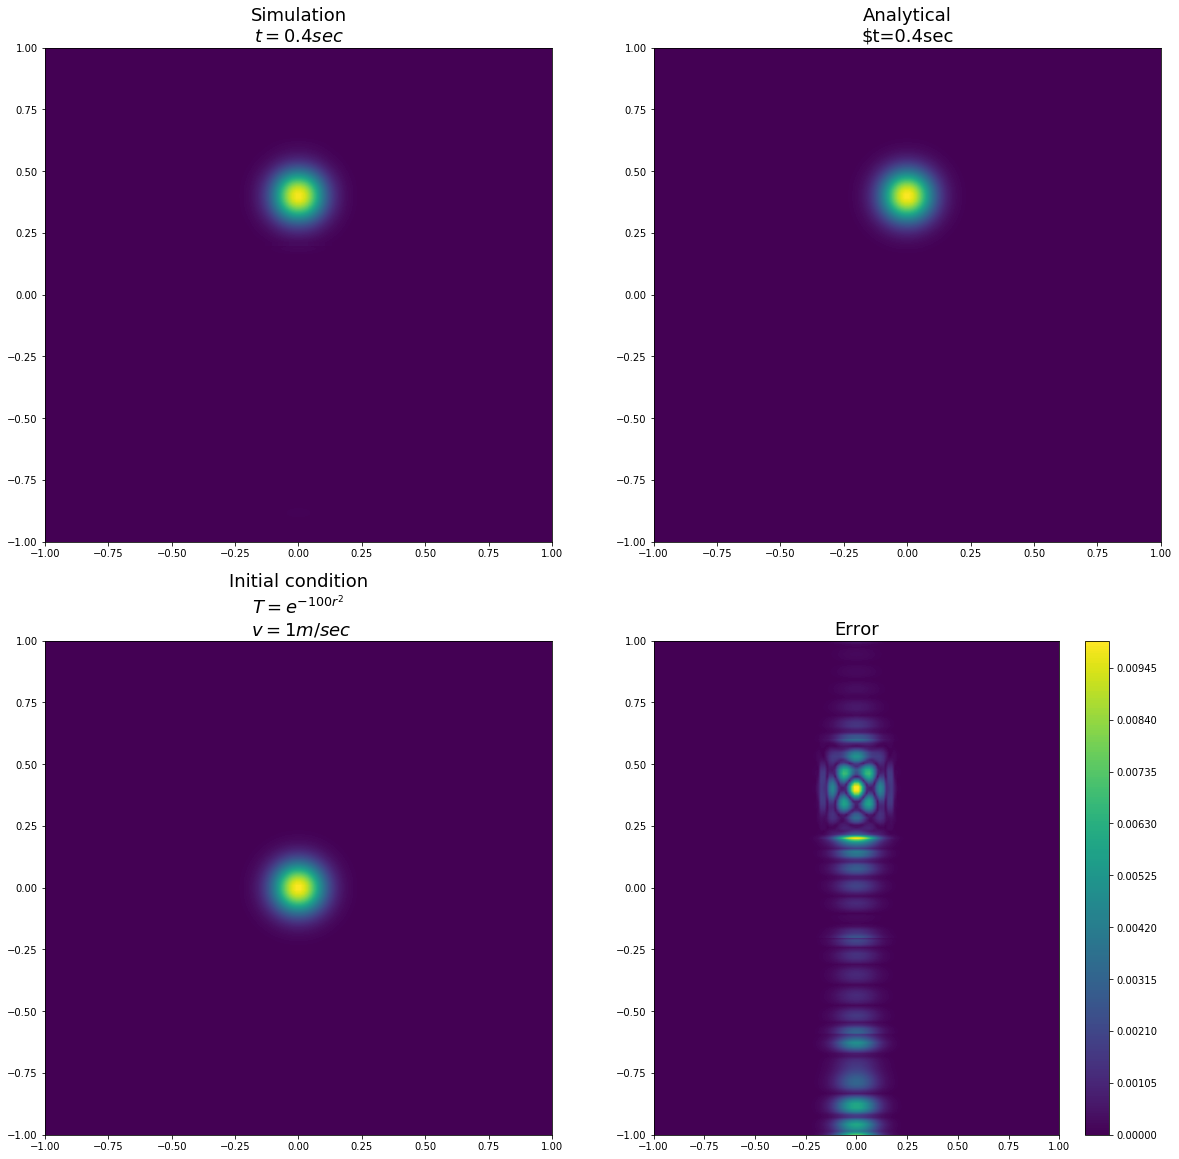

In [55]:
plt.show()

## Pressure poisson equation

Solving Incompressible NS is a computationally difficult task because of the strong coupling between the pressure and velocity terms. We use the pressure poisson approach to solve the continuity and momentum equation simultaneously. The pressure poisson equation is obtained by taking the divergence of the momentum equation.

### The approach:

* Compute $u^*$ using the latest pressure and velocity from the last time step
* Compute P from $u^*$ using the pressure poisson equation $\nabla^2 P = - \nabla \cdot ((u^*.\nabla)u^*)$
* Repeat the steps till convergence.

Note that in incompressible flows, the speed of sound is infinite. That in information travels infinitely fast. A small perturbation in velocity ant one corner of the system can instantaneously change the pressure in another corner. The methods we use to solve this equation will thus be global. We first construct a laplacian matrix. The approach is essentially the same as that used for difussion terms. However, there, we had to get from a variable to its laplacian. Here, we have to take the inverse of a laplaian to compute the pressure. We thus have to "substitute" out the intermediate term and construct a global Laplacian matrix that when multtiplied with a global variable vector gives the laplacian.

This is a Work in Progress as I haven't been able to iron the bugs out. The aim is to finish this during the winters.

# Implementation details

- Used vectorized implementations to compute every matrix
- Lobatto nodes computed using newton raphson. Initial guess: cos of equidistant points. Accurate up to ~50 nodes
- Highly modular code.
- "System" class contains a collection of elements. Has APIs that allow you yo get system variables interpolated to arbitrary set of nodes.
- "Element" class contains most of the actual implementation of Galerkin methods for a single element.
- matrix_generator, lobatto, interpolation and utilities files define various functions used heavily in DG.
- Code can be found at https://github.com/manandoshi/NSDG-python
- C++ implementation built on Kaushik's work https://github.com/manandoshi/NavierStokes-DG. Does not have vectorized implementations and bugs out on higher orders, but is much faster.